In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pickle
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Getting Dataset

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

## Making the data 3d and 224x224

In [4]:
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import zoom

length = len(train_dataset.data)
train_data = []

for x in range(length):

    test, target = train_dataset.__getitem__(x)
    
    test = test.unsqueeze(0)
    
    desired_shape = (224, 224)
    resized_image = F.interpolate(test, size=desired_shape, mode='bilinear', align_corners=False)
    
    resized_image = resized_image.squeeze(0).squeeze(0)
    resized_image = resized_image.numpy()

    new_image = np.array([resized_image,resized_image,resized_image])
    new_image = torch.tensor(new_image)
    
    train_data.insert(x, [new_image, target])

test_file = '3d_224_test.pkl'

with open(os.getcwd() + '/data/pickle_out/' + test_file, 'rb') as file:
    test_data = pickle.load(file)

In [5]:
# FOR DUMPING OUT THE 3D TENSORS

# file_name = '3d_224_train.pkl' 

# with open(os.getcwd() + '/data/pickle_out/' + file_name, 'wb') as file:
#     pickle.dump(new_data, file)

In [6]:
from utils import FashionMnist_Dataset

train_dataset = FashionMnist_Dataset(train_data)
test_dataset = FashionMnist_Dataset(test_data)

BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
from utils import train_loop, test_loop, EarlyStopper
from pretrained_model import googleNet_pretrained

num_epochs = 60
lr = 0.001
patience = 5

early_stopper = EarlyStopper(patience=patience, min_delta=0)
model = googleNet_pretrained(train_last_layer_only= False)

model.to(device= device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

tr_acc, te_acc = [], []
tr_loss, te_loss = [], []

best_acc = 0

for epoch in range(num_epochs):
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer, device, cutmix=True)
    test_loss, test_correct = test_loop(test_loader, model, loss_fn, device)

    print('Train Acc epoch {} : {} '.format(epoch, train_correct))
    print('Test Acc epoch {} : {} '.format(epoch, test_correct))

    tr_acc.append(train_correct)
    te_acc.append(test_correct)

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    if early_stopper.early_stop(test_loss):
        print("Done! Early stopped at {}".format(epoch))
        break



Using cache found in C:\Users\ianch/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop

Train Acc epoch 0 : 0.8776 
Test Acc epoch 0 : 0.9166 
Train Acc epoch 1 : 0.9227666666666666 
Test Acc epoch 1 : 0.927 
Train Acc epoch 2 : 0.9350833333333334 
Test Acc epoch 2 : 0.9328 
Train Acc epoch 3 : 0.9415666666666667 
Test Acc epoch 3 : 0.9389 
Train Acc epoch 4 : 0.9465 
Test Acc epoch 4 : 0.9428 
Train Acc epoch 5 : 0.9511166666666667 
Test Acc epoch 5 : 0.9483 
Train Acc epoch 6 : 0.9547666666666667 
Test Acc epoch 6 : 0.9482 
Train Acc epoch 7 : 0.95615 
Test Acc epoch 7 : 0.9576 
Train Acc epoch 8 : 0.9602 
Test Acc epoch 8 : 0.9617 
Train Acc epoch 9 : 0.9634333333333334 
Test Acc epoch 9 : 0.9647 
Train Acc epoch 10 : 0.9646 
Test Acc epoch 10 : 0.9697 
Train Acc epoch 11 : 0.96855 
Test Acc epoch 11 : 0.9701 
Train Acc epoch 12 : 0.9693166666666667 
Test Acc epoch 12 : 0.9719 
Train Acc epoch 13 : 0.9737 
Test Acc epoch 13 : 0.9774 
Train Acc epoch 14 : 0.9756833333333333 
Test Acc epoch 14 : 0.9794 
Train Acc epoch 15 : 0.9764333333333334 
Test Acc epoch 15 : 0.981 


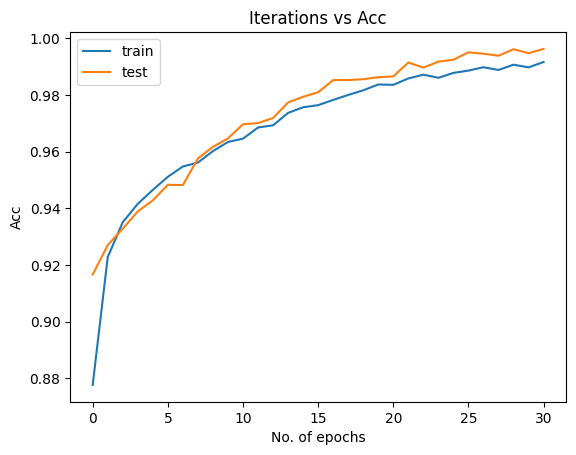

In [13]:
plt.plot(range(epoch+1), tr_acc, label='train')
plt.plot(range(epoch+1), te_acc, label='test')

plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Acc")
plt.title("Iterations vs Acc")
plt.show()

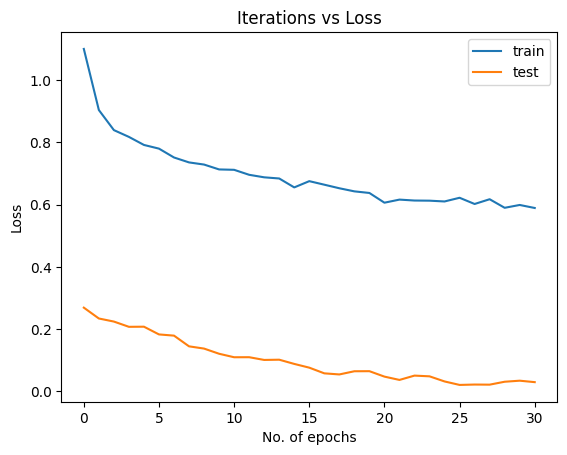

: 

In [14]:
plt.plot(range(epoch+1), tr_loss, label='train')
plt.plot(range(epoch+1), te_loss, label='test')
plt.xlabel("No. of epochs")
plt.ylabel("Loss")

plt.legend()
plt.title("Iterations vs Loss")
plt.show()

In [10]:
print("Best Acc : {} | Best Epoch : {}".format(max(te_acc), te_acc.index(max(te_acc))))

Best Acc : 0.9963 | Best Epoch : 30


## Pickle out results and accuracies

In [11]:
import pickle
import os

file_name = 'pretrained_googlenet_unfreeze_cutmix.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'wb') as file:
    pickle.dump(tr_acc, file)
    pickle.dump(te_acc, file)
    pickle.dump(tr_loss, file)
    pickle.dump(te_loss, file)

## Pickle in results and accuracies

In [15]:
file_name = 'pretrained_googlenet_unfreeze_cutmix.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'rb') as file:
    tr_acc = pickle.load(file)
    te_acc = pickle.load(file)
    tr_loss = pickle.load(file)
    te_loss = pickle.load(file)


print(tr_acc)
print(te_acc)
print(tr_loss)
print(te_loss)

[0.8420333333333333, 0.8942, 0.9144833333333333, 0.9263833333333333, 0.9390333333333334, 0.9486, 0.9566833333333333, 0.9639333333333333, 0.96975, 0.9731666666666666, 0.97645, 0.9785333333333334, 0.9806333333333334, 0.9828, 0.9842333333333333, 0.9857, 0.9868666666666667, 0.9869, 0.9870833333333333, 0.9889, 0.9894333333333334, 0.9887666666666667, 0.9907833333333333, 0.9899]
[0.8899, 0.9098, 0.9305, 0.9344, 0.9451, 0.9533, 0.9604, 0.9573, 0.9446, 0.9634, 0.9599, 0.9692, 0.975, 0.9792, 0.9737, 0.9737, 0.9844, 0.9773, 0.9894, 0.9821, 0.9849, 0.9865, 0.9894, 0.9862]
[0.4539341896834783, 0.29724150975283703, 0.23936005581675562, 0.20553365839910692, 0.17077942168516674, 0.14441650747307722, 0.11986084810852553, 0.09995775003782055, 0.08466551990749495, 0.07275770507576299, 0.06505188774009972, 0.06180197454411224, 0.05448366027852584, 0.04823133617738789, 0.04571720627575637, 0.04224015526449567, 0.03937546303991107, 0.03728256960236743, 0.03894853849388477, 0.031703032937102645, 0.0305610840